In [32]:
from astropy.io import ascii
from MyToolkit import *
from Clustering_module import *
from astropy import units as u
from astropy.io import fits

DP2_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/"

In [37]:
def make_shen_random_catalog(ra_col, dec_col, init_level, resol_upgrd):
    map_now = healpix_sky_map_ps1_cover_area(ra_col, dec_col, init_level)
    map_now = map_now[1]

    map_then = hp.pixelfunc.ud_grade(map_now, 2 ** resol_upgrd)

    map_random = np.zeros_like(map_then)
    val_pos = np.where(map_then != 0)
    num_pix = len(val_pos[0])
    rand = np.random.randint(0, num_pix, 6056)
    rand_pos = val_pos[0][rand]
    map_random[rand_pos] = 1

    rand_ang = hp.pixelfunc.pix2ang(2**resol_upgrd, rand_pos, lonlat=True)

    rand_ra_col = rand_ang[0]
    rand_dec_col = rand_ang[1]
    rand_red_col = np.random.uniform(2.9, 5.4, len(rand_ra_col))

    return rand_ra_col, rand_dec_col, rand_red_col

### Trying to get the exact sample used in Shen

There are 46420 quasars in the catalog


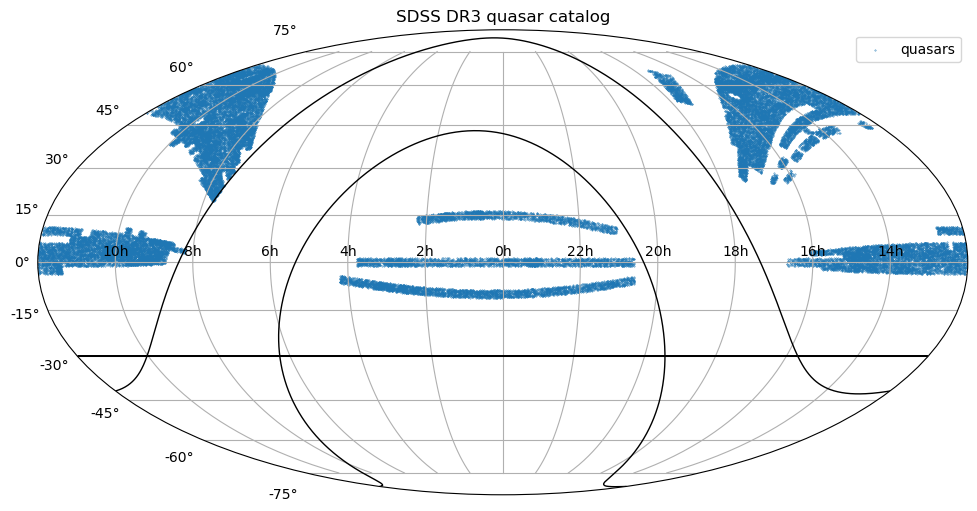

In [40]:
schneider_2005_file_name = DP2_DIRECTORY + "Data/SDSS_DR3_datafile2.txt"
schneider_2005_data = ascii.read(schneider_2005_file_name)
ra_col_schneider_2005 = schneider_2005_data.columns[1].value
dec_col_schneider_2005 = schneider_2005_data.columns[2].value
red_col_schneider_2005 = schneider_2005_data.columns[3].value

print("There are {} quasars in the catalog".format(len(ra_col_schneider_2005)))
ax = plot_sky_map_ps1(ra_col_schneider_2005, dec_col_schneider_2005, labels=['quasars'], title="SDSS DR3 quasar catalog", mark_size=0.1)

There are 3333 quasars with z > 2.9 in the SDSS DR3 catalog


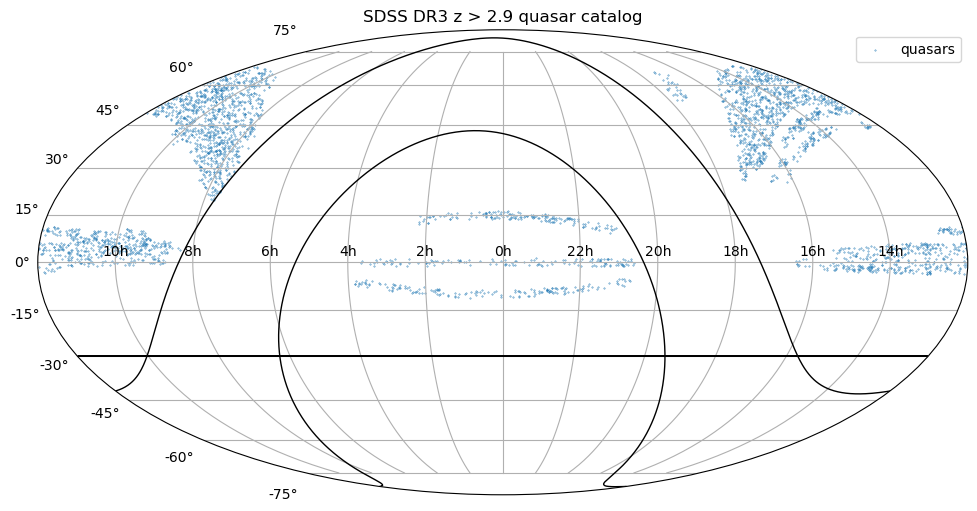

In [41]:
# Taking all the z > 2.9 quasars from the SDSS DR3
pos_z2_9 = np.where(red_col_schneider_2005 > 2.9)

ra_col_DR3 = ra_col_schneider_2005[pos_z2_9]
dec_col_DR3 = dec_col_schneider_2005[pos_z2_9]
red_col_DR3 = red_col_schneider_2005[pos_z2_9]

print("There are {} quasars with z > 2.9 in the SDSS DR3 catalog".format(len(ra_col_DR3)))
ax = plot_sky_map_ps1(ra_col_DR3, dec_col_DR3, labels=['quasars'], title="SDSS DR3 z > 2.9 quasar catalog", mark_size=0.1)

### Sample used here are from Schneider 2006, SDSS DR5 quasar catalog

In [2]:
schneider_file_name = DP2_DIRECTORY + "Data/SDSS_DR5_datafile2.txt"
schneider_data = ascii.read(schneider_file_name)
ra_col_schneider = schneider_data.columns[1].value
dec_col_schneider = schneider_data.columns[2].value
red_col_schneider = schneider_data.columns[3].value

There are 77429 quasars in the catalog


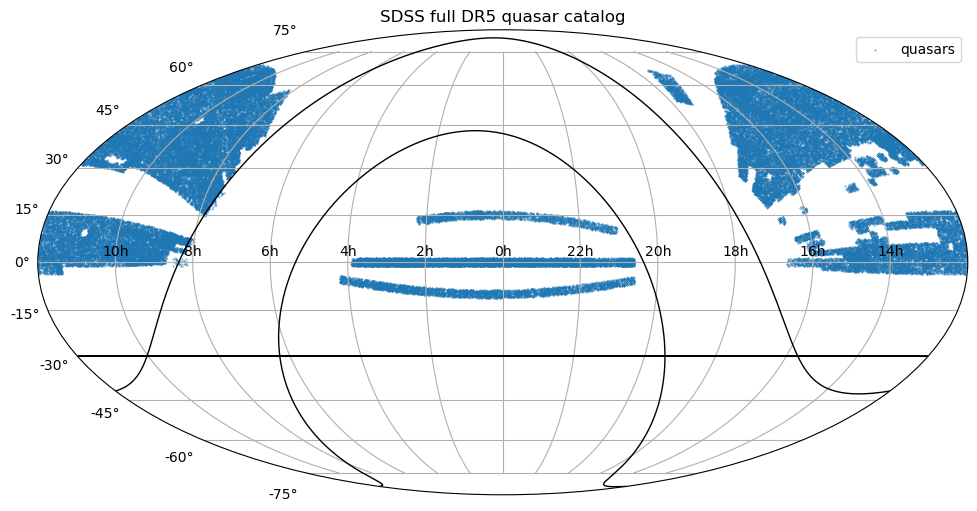

In [4]:
print("There are {} quasars in the catalog".format(len(ra_col_schneider)))
ax = plot_sky_map_ps1(ra_col_schneider, dec_col_schneider, labels=['quasars'], title="SDSS full DR5 quasar catalog", mark_size=0.1)

There are 6056 quasars in the catalog


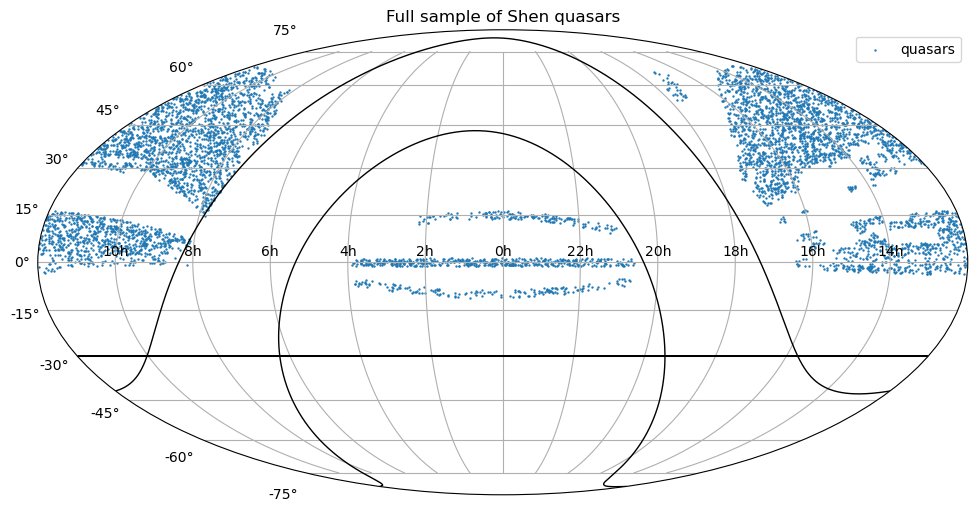

In [46]:
pos_shen = np.where((red_col_schneider >= 2.9) & (red_col_schneider <= 5.4))
print("There are {} quasars in the catalog".format(len(pos_shen[0])))
ra_col_shen = ra_col_schneider[pos_shen]
dec_col_shen = dec_col_schneider[pos_shen]
red_col_shen = red_col_schneider[pos_shen]
ax = plot_sky_map_ps1(ra_col_shen, dec_col_shen, labels=['quasars'], title="Full sample of Shen quasars", mark_size=0.5)

Level    coverage area
    5      7224.63970
    6      6389.54252
    7      5394.55990
    8      2812.99756
    9      917.63646
   10      247.54245


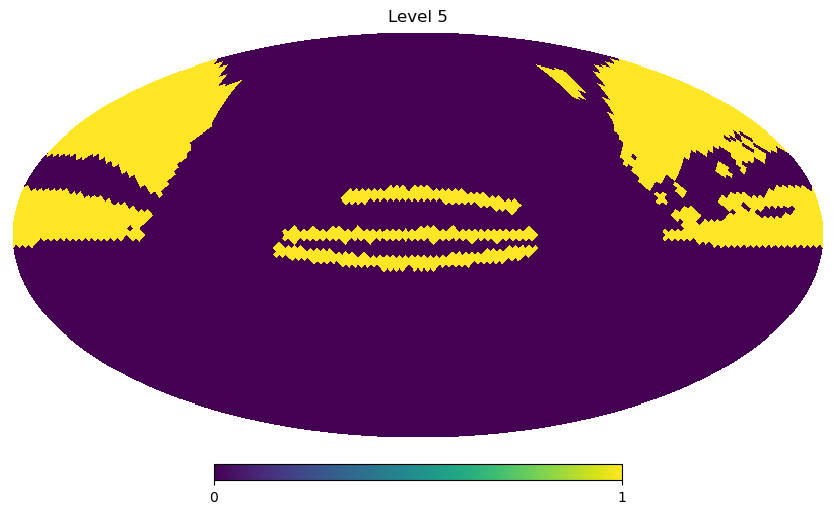

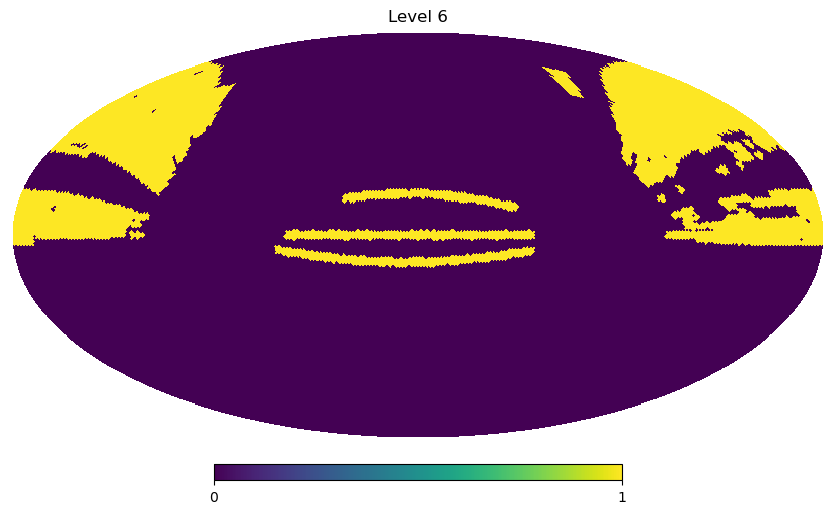

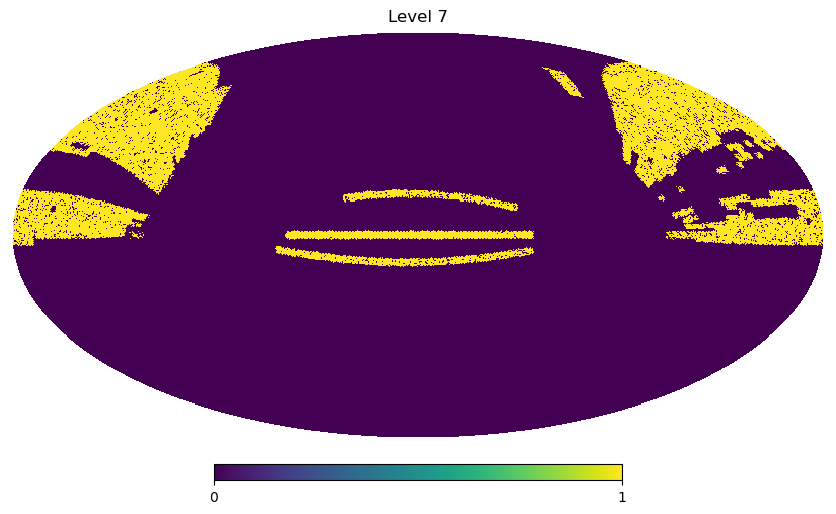

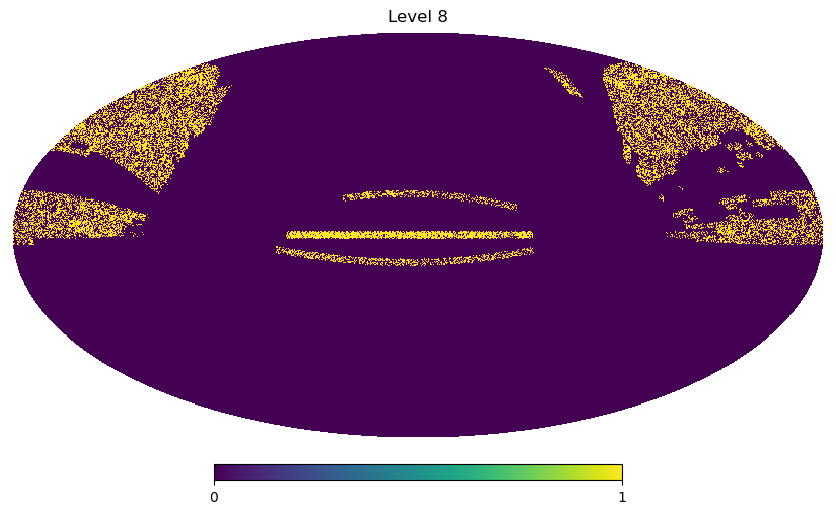

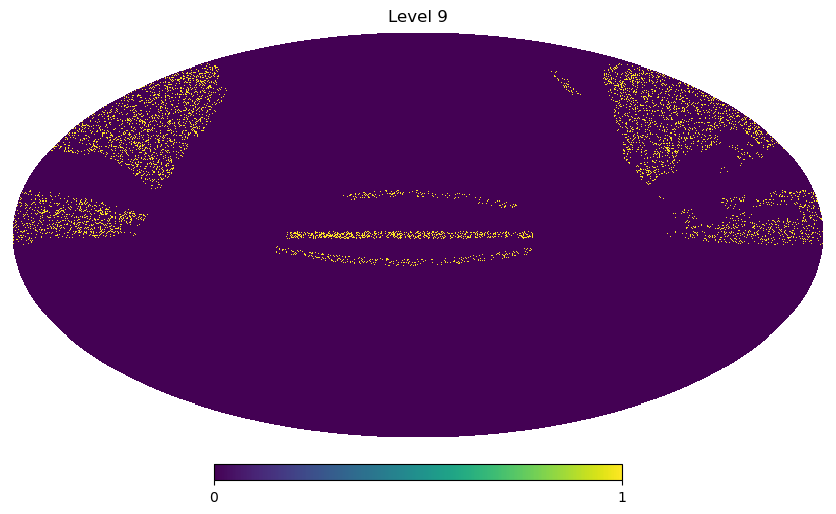

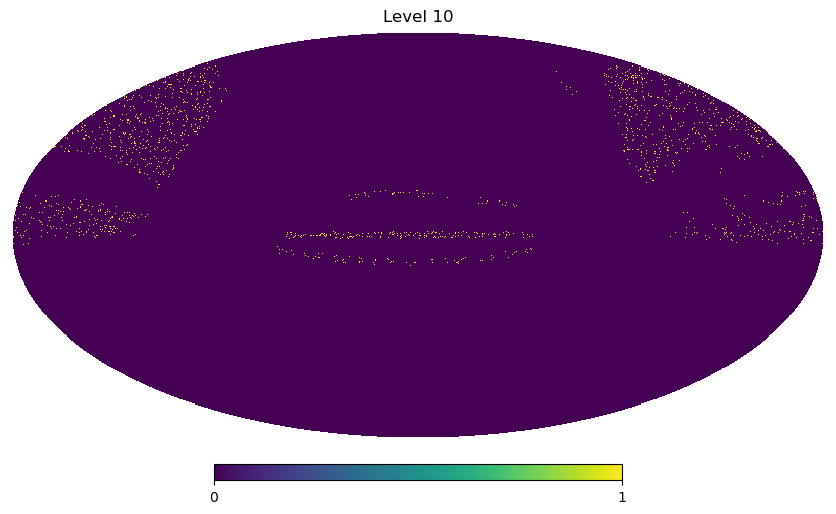

In [12]:
level = []
cov_area = []
print("Level    coverage area")
for i in [5,6,7,8,9,10]:
    map_i, wat = healpix_sky_map_ps1_cover_area(ra_col_schneider, dec_col_schneider, i, title="Level " + str(i))
    level.append(i)
    cov_area.append(map_i)
    print(f'{i:5d}      {map_i:8.5f}')

[7224.639697977724, 6389.5425209926125, 5394.559904594775, 2812.997563630877, 917.6364614063466, 247.5424479752701]


Text(0, 0.5, 'Effective coverage area')

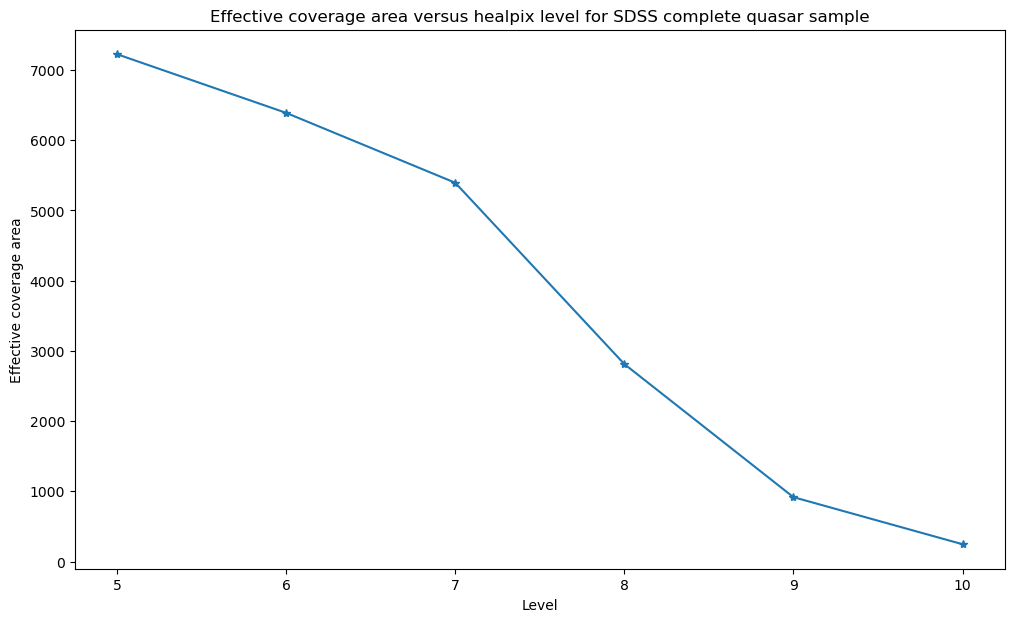

In [7]:
print(cov_area)
fig, ax = plt.subplots(figsize = (12, 7))
ax.plot(level, cov_area, '*-')
ax.set_title("Effective coverage area versus healpix level for SDSS complete quasar sample")
ax.set_xlabel("Level")
ax.set_ylabel("Effective coverage area")

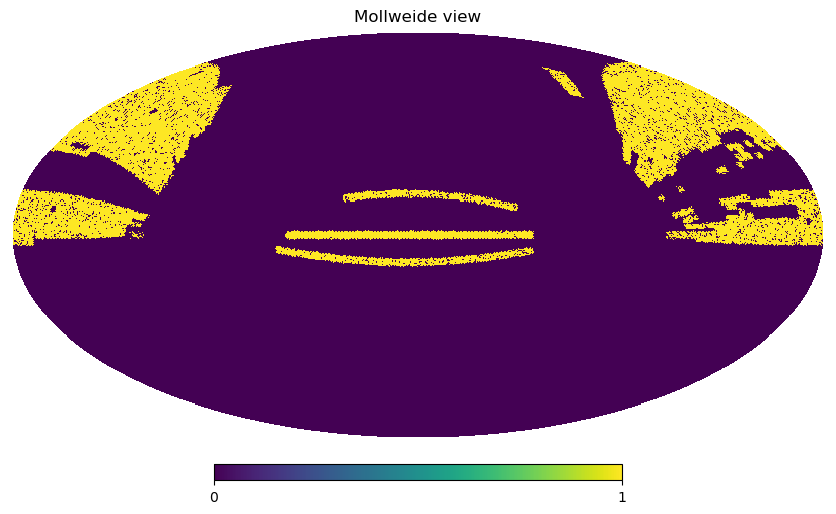

In [8]:
map_now = healpix_sky_map_ps1_cover_area(ra_col_schneider, dec_col_schneider, 7)
map_now = map_now[1]

25710 411360


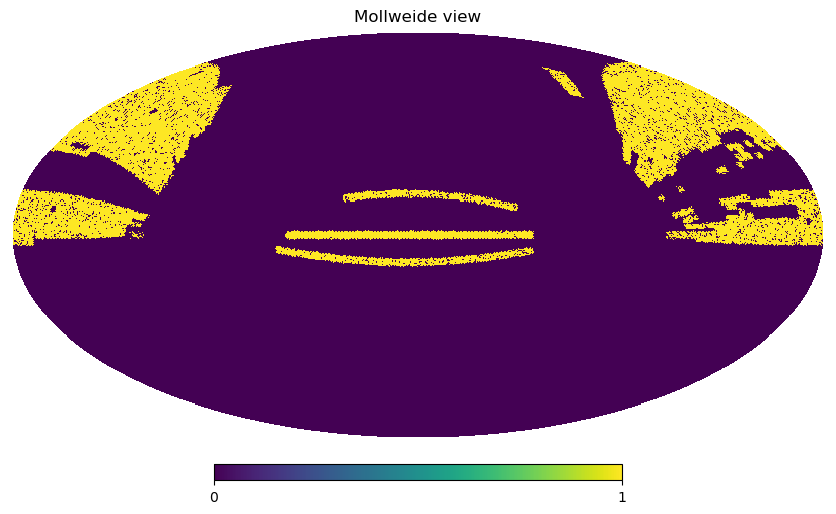

In [9]:
map_then = hp.pixelfunc.ud_grade(map_now, 2 ** 9)
hp.mollview(map_then)
print(len(np.where(map_now != 0)[0]), len(np.where(map_then != 0)[0]))

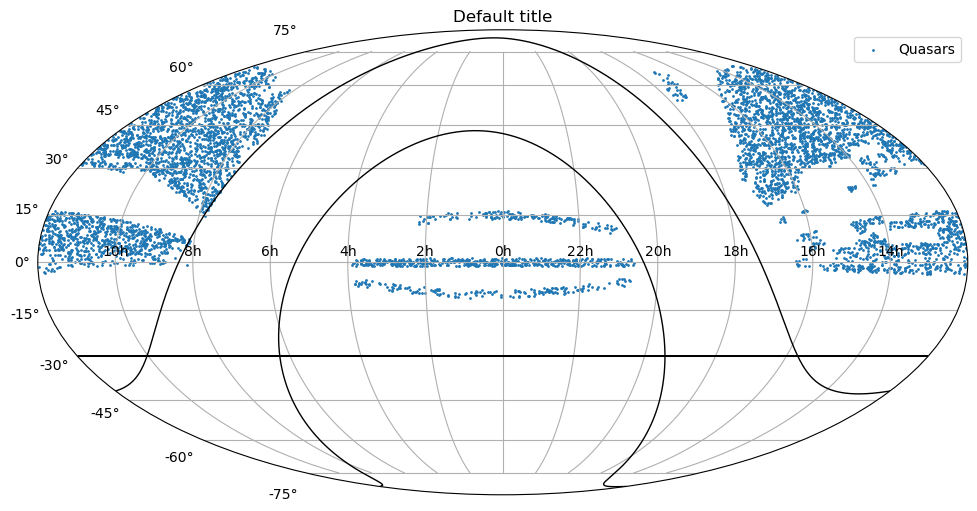

<MollweideAxes: title={'center': 'Default title'}>

In [10]:
plot_sky_map_ps1(ra_col_shen, dec_col_shen, ['Quasars'], mark_size=1)

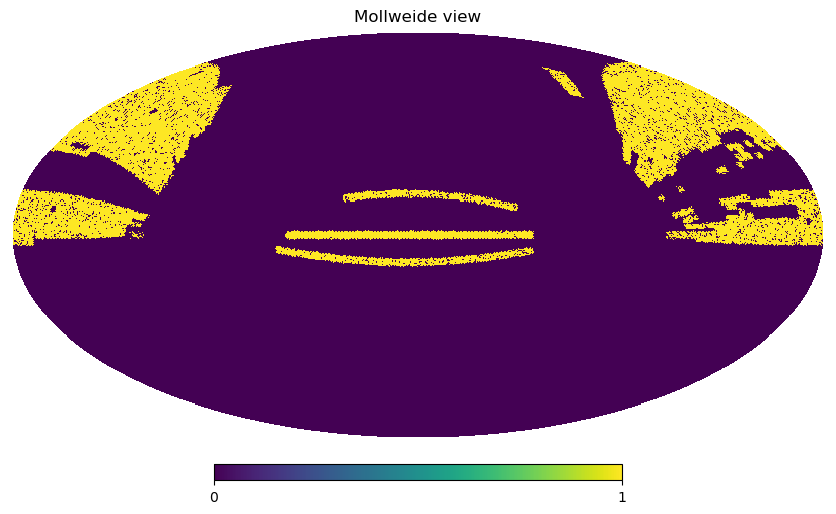

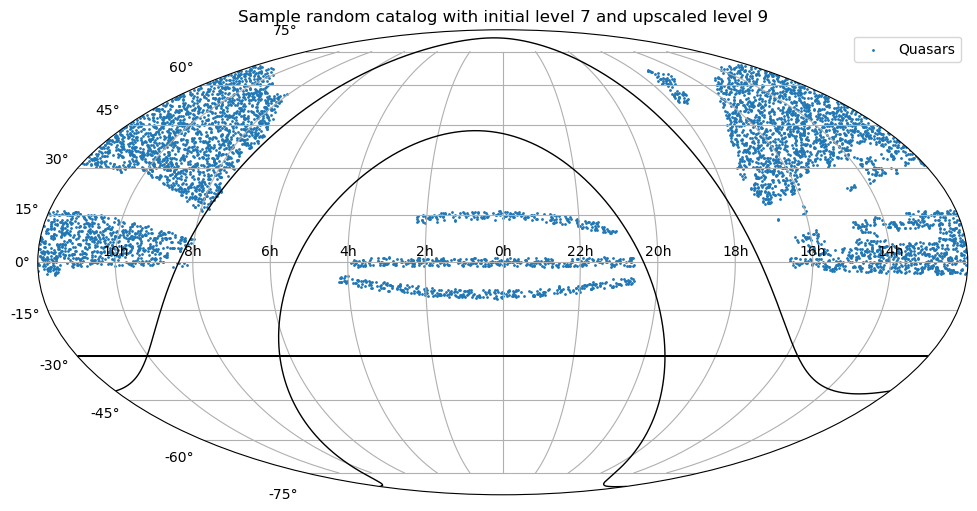

<MollweideAxes: title={'center': 'Sample random catalog with initial level 7 and upscaled level 9'}>

In [25]:
rand_ra_col, rand_dec_col, rand_red_col = make_shen_random_catalog(7, 9)
plot_sky_map_ps1(rand_ra_col, rand_dec_col, ["Quasars"], title="Sample random catalog with initial level 7 and upscaled level 9", mark_size=1)

Text(0.5, 1.0, 'Redshift space clustering of Shen quasars')

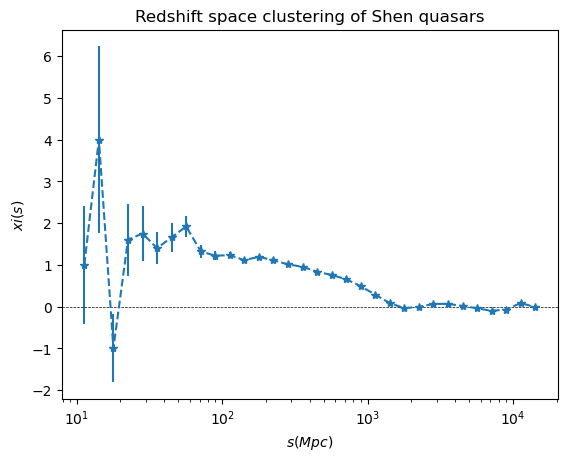

In [20]:
rand_ra_col, rand_dec_col, rand_red_col = make_shen_random_catalog(ra_col_schneider, dec_col_schneider, 7, 9)

ax = find_xi_s(ra_col_shen, dec_col_shen, red_col_shen, "Shen_redshift_space_corr_table_real_signal", \
          rand_ra = rand_ra_col, rand_dec = rand_dec_col, rand_red=rand_red_col)
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim((0,100))
ax.set_title('Redshift space clustering of Shen quasars')

Text(0.5, 1.0, 'Redshift space clustering of Shen quasars')

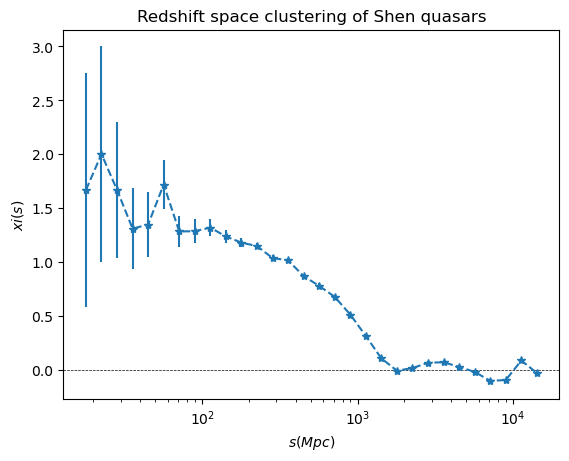

In [30]:
rand_ra_col, rand_dec_col, rand_red_col = make_shen_random_catalog(ra_col_schneider, dec_col_schneider, 7, 11)

ax = find_xi_s(ra_col_shen, dec_col_shen, red_col_shen, "Shen_redshift_space_corr_table_real_signal", \
          rand_ra = rand_ra_col, rand_dec = rand_dec_col, rand_red=rand_red_col)
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim((0,100))
ax.set_title('Redshift space clustering of Shen quasars')

In [35]:
fits_file_name = DP2_DIRECTORY + "Data/eBOSS_QSO_clustering_random-NGC-vDR16.fits"
fits_file = fits.open(fits_file_name)
image_data = fits.getdata(fits_file, ext=0)

TypeError: stat: path should be string, bytes, os.PathLike or integer, not method

### Actual Shen quasar sample

There are 4426 quasars in the catalog


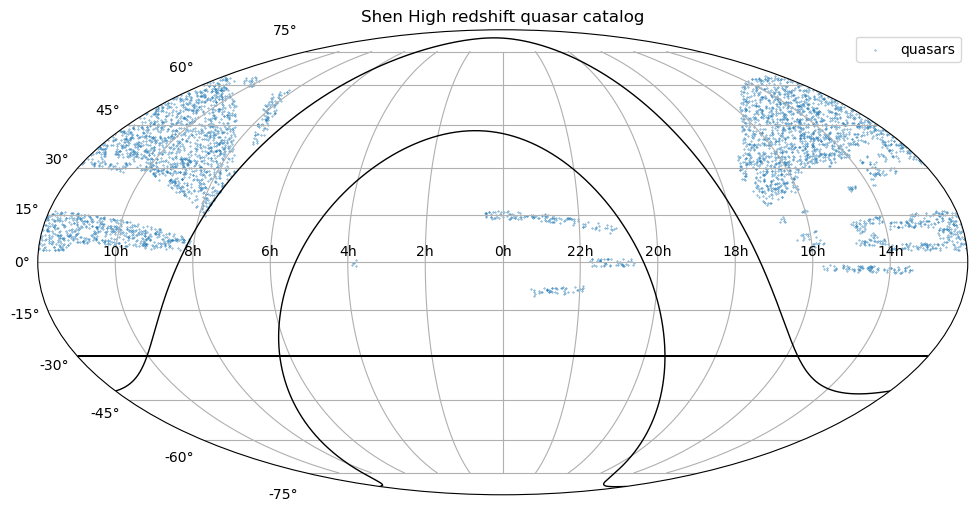

In [69]:
shen_file_name = DP2_DIRECTORY + "Data/shen_quasar_sample_datafile1.txt"
shen_data = ascii.read(shen_file_name)
sub_flag = shen_data.columns[8]
good_flag = shen_data.columns[9]
pos = np.where(sub_flag == 1)
pos_good = np.where(good_flag == 1)
ra_col_shen = shen_data.columns[3][pos]
dec_col_shen = shen_data.columns[4][pos]
red_col_shen = shen_data.columns[5][pos]

ra_col_shen_good = shen_data.columns[3][pos_good]
dec_col_shen_good = shen_data.columns[4][pos_good]
red_col_shen_good = shen_data.columns[5][pos_good]

print("There are {} quasars in the catalog".format(len(ra_col_shen)))
ax = plot_sky_map_ps1(ra_col_shen, dec_col_shen, labels=['quasars'], title="Shen High redshift quasar catalog", mark_size=0.1)

[2.901 2.951 3.001 3.051 3.101 3.151 3.201 3.251 3.301 3.351 3.401 3.451
 3.501 3.551 3.601 3.651 3.701 3.751 3.801 3.851 3.901 3.951 4.001 4.051
 4.101 4.151 4.201 4.251 4.301 4.351 4.401 4.451 4.501 4.551 4.601 4.651
 4.701 4.751 4.801 4.851 4.901 4.951 5.001 5.051 5.101 5.151 5.201 5.251
 5.301 5.351]


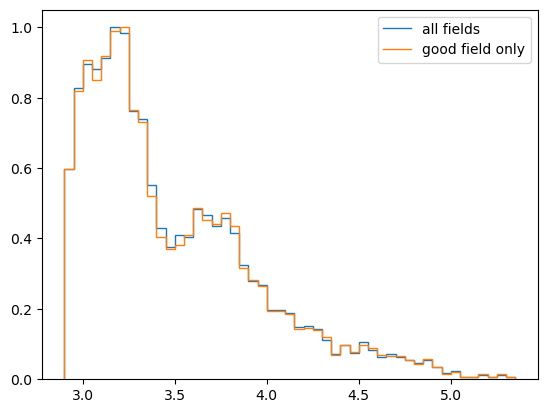

In [71]:
bins = [2.901 + i*0.05 for i in range(50)]
hist, edges = np.histogram(red_col_shen, bins=bins)
hist_good, edges_good = np.histogram(red_col_shen_good, bins=bins)
print(edges)
hist = hist/np.max(hist)
hist_good = hist_good/np.max(hist_good)

plt.stairs(hist, edges, label="all fields")
plt.stairs(hist_good, edges, label="good field only")
plt.legend()

In [89]:
log_bin = [round(pow(10,i * 0.1 + np.log10(2.244)),3) for i in range(0,22)]